In [10]:
from google.colab import drive
drive.mount("/content/drive")

import os
import sys
import tensorflow as tf

# Projektets rot i Google Drive
PROJECT_DIR = "/content/drive/MyDrive/sepsis-timeline-project"
SRC_DIR = f"{PROJECT_DIR}/src"

# Byt arbetskatalog till projektroten
os.chdir(PROJECT_DIR)

# Lägg src/ i PYTHONPATH (stabilast i Colab)
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

# Sanity checks
print("✅ Current working directory:", os.getcwd())
print("✅ src/ in sys.path:", SRC_DIR in sys.path)
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU available:", tf.config.list_physical_devices("GPU"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Current working directory: /content/drive/MyDrive/sepsis-timeline-project
✅ src/ in sys.path: True
✅ TensorFlow version: 2.19.0
✅ GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Steg 11 — Transformer-modell (dev5000)

I den här notebooken:
1) Laddar jag de preprocessade train/val/test-tensorerna från `data/processed/dev5000/`
2) Bygger en enkel Transformer-encoder (baseline) i Keras för tidsseriedata
3) Tränar med class weights + callbacks (EarlyStopping + Checkpoint + ReduceLR)
4) Utvärderar på val och test (ROC-AUC, PR-AUC, confusion matrix)
5) Sparar figurer till `outputs/figures/` med konsekventa namn så jag kan använda dem i LaTeX-rapporten


In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----------------------------
# Var vi läser data och sparar output
# ----------------------------
PROCESSED_NAME = "dev5000"
DATA_DIR = os.path.join(PROJECT_DIR, "data", "processed", PROCESSED_NAME)

FIG_DIR  = os.path.join(PROJECT_DIR, "outputs", "figures")
CKPT_DIR = os.path.join(PROJECT_DIR, "outputs", "checkpoints")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

print("✅ DATA_DIR:", DATA_DIR)
print("✅ FIG_DIR :", FIG_DIR)
print("✅ CKPT_DIR:", CKPT_DIR)


✅ DATA_DIR: /content/drive/MyDrive/sepsis-timeline-project/data/processed/dev5000
✅ FIG_DIR : /content/drive/MyDrive/sepsis-timeline-project/outputs/figures
✅ CKPT_DIR: /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints


In [12]:
train_X = np.load(os.path.join(DATA_DIR, "train_X.npy"))
train_y = np.load(os.path.join(DATA_DIR, "train_y.npy"))

val_X = np.load(os.path.join(DATA_DIR, "val_X.npy"))
val_y = np.load(os.path.join(DATA_DIR, "val_y.npy"))

test_X = np.load(os.path.join(DATA_DIR, "test_X.npy"))
test_y = np.load(os.path.join(DATA_DIR, "test_y.npy"))

print("✅ train_X:", train_X.shape, "train_y:", train_y.shape, "pos_rate:", train_y.mean())
print("✅ val_X  :", val_X.shape,   "val_y  :", val_y.shape,   "pos_rate:", val_y.mean())
print("✅ test_X :", test_X.shape,  "test_y :", test_y.shape,  "pos_rate:", test_y.mean())

# Spara meta om du vill visa i rapporten
meta_path = os.path.join(DATA_DIR, "meta.json")
if os.path.exists(meta_path):
    with open(meta_path, "r") as f:
        meta = json.load(f)
    print("✅ meta.json hittad. Nycklar:", list(meta.keys()))
else:
    meta = None
    print("⚠️ meta.json hittades inte (det är ok).")


✅ train_X: (12825, 48, 80) train_y: (12825,) pos_rate: 0.1352046783625731
✅ val_X  : (2893, 48, 80) val_y  : (2893,) pos_rate: 0.11959903214656066
✅ test_X : (2878, 48, 80) test_y : (2878,) pos_rate: 0.1296038915913829
✅ meta.json hittad. Nycklar: ['tag', 'seed', 'N_PATIENTS', 'T', 'H', 'n_features_raw', 'n_features_model', 'feature_cols', 'train_shape', 'val_shape', 'test_shape', 'train_pos_rate', 'val_pos_rate', 'test_pos_rate']


In [13]:
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=train_y)
class_weight = {0: float(cw[0]), 1: float(cw[1])}

print("✅ class_weight:", class_weight)


✅ class_weight: {0: 0.5781714903976197, 1: 3.6980968858131487}


In [14]:
BATCH_SIZE = 128

train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_ds = train_ds.shuffle(10_000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ tf.data pipelines klara.")


✅ tf.data pipelines klara.


In [15]:
## Transformer-block (enkelt & robust)

def transformer_encoder_block(x, head_size, num_heads, ff_dim, dropout=0.1):
    """
    En enkel Transformer encoder-block:
    - Multi-Head Self-Attention + residual
    - Feed-forward + residual
    """
    # Self-attention
    attn_out = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout
    )(x, x)

    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward
    ff_out = layers.Dense(ff_dim, activation="relu")(x)
    ff_out = layers.Dropout(dropout)(ff_out)
    ff_out = layers.Dense(x.shape[-1])(ff_out)

    x = layers.Add()([x, ff_out])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x


def build_transformer_model(seq_len, num_features,
                            d_model=64,
                            num_blocks=2,
                            head_size=32,
                            num_heads=4,
                            ff_dim=128,
                            dropout=0.15):
    """
    Transformer baseline för tidsserier (T, F).
    """
    inputs = keras.Input(shape=(seq_len, num_features), name="timeseries")

    # 1) Projicera features -> d_model
    x = layers.Dense(d_model)(inputs)

    # 2) Positional embeddings (lärda)
    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_emb = layers.Embedding(input_dim=seq_len, output_dim=d_model)(positions)
    x = x + pos_emb

    x = layers.Dropout(dropout)(x)

    # 3) Encoder-blocks
    for _ in range(num_blocks):
        x = transformer_encoder_block(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    # 4) Pooling över tid
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])

    # 5) Klassificerings-head
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid", name="p_sepsis")(x)

    model = keras.Model(inputs, outputs, name="transformer_baseline")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.AUC(name="pr_auc", curve="PR"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )
    return model


SEQ_LEN = train_X.shape[1]
NUM_FEATURES = train_X.shape[2]

model = build_transformer_model(SEQ_LEN, NUM_FEATURES)
model.summary()



Model: "transformer_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timeseries          │ (None, 48, 80)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 48, 64)    │      5,184 │ timeseries[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 48, 64)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 48, 64)    │          0 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     33,216 │ dropout_7[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 48, 64)    │          0 │ dropout_7[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 48, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 48, 128)   │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 48, 64)    │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 48, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     33,216 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 48, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 48, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 48, 128)   │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 48, 64)    │      8,256 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 48, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 130,113 (508.25 KB)

 Trainable params: 130,113 (508.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
## Callbacks (monitorera val_pr_auc)
MODEL_TAG = f"transformer_baseline_{PROCESSED_NAME}"

ckpt_path = os.path.join(CKPT_DIR, f"best_{MODEL_TAG}.keras")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_pr_auc",
        mode="max",
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_pr_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_pr_auc",
        mode="max",
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        verbose=1
    )
]

print("✅ Callbacks klara, checkpoint ->", ckpt_path)


✅ Callbacks klara, checkpoint -> /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_transformer_baseline_dev5000.keras


In [17]:
# träna modellen
EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - auc: 0.5855 - loss: 0.7049 - pr_auc: 0.1721 - precision: 0.1712 - recall: 0.5717
Epoch 1: val_pr_auc improved from -inf to 0.17123, saving model to /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_transformer_baseline_dev5000.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - auc: 0.5863 - loss: 0.7044 - pr_auc: 0.1725 - precision: 0.1715 - recall: 0.5724 - val_auc: 0.6197 - val_loss: 0.6868 - val_pr_auc: 0.1712 - val_precision: 0.1500 - val_recall: 0.7197 - learning_rate: 0.0010
Epoch 2/30
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8325 - loss: 0.4888 - pr_auc: 0.3988 - precision: 0.2821 - recall: 0.8495
Epoch 2: val_pr_auc improved from 0.17123 to 0.26162, saving model to /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_transformer_baseline_dev5000.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8331 - loss: 0.4880 - pr_auc: 0.4000 - precision: 0.2828 - recall: 0.8498 

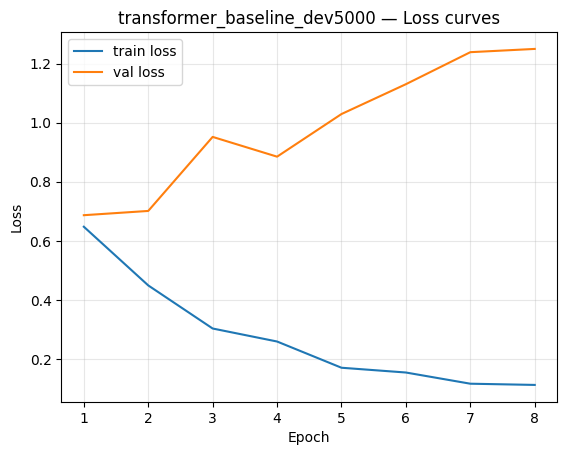

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_learning_loss.png


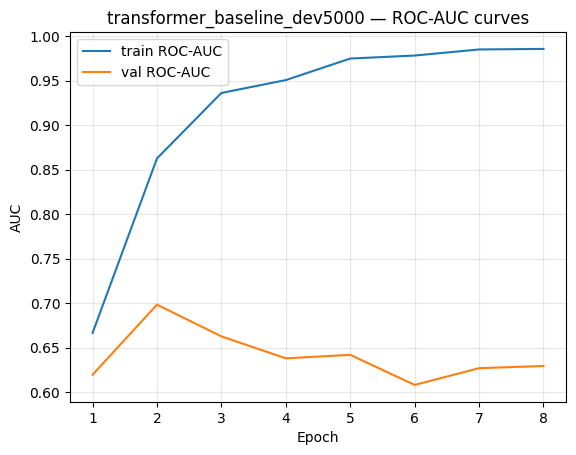

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_learning_auc.png


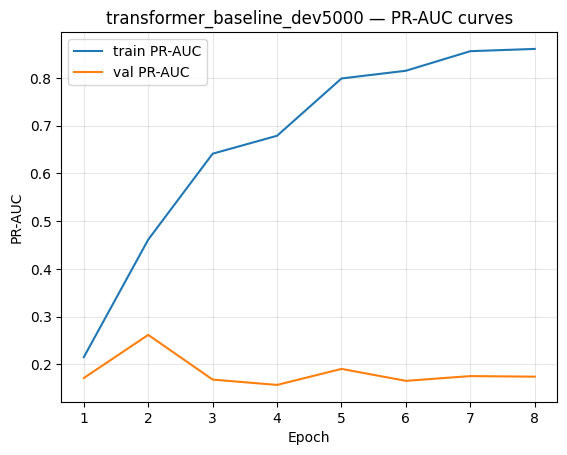

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_learning_pr_auc.png


In [18]:
## Plotta learning curves (loss + ROC-AUC + PR-AUC)

hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

# ---- LOSS ----
plt.figure()
plt.plot(epochs, hist["loss"], label="train loss")
plt.plot(epochs, hist["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"{MODEL_TAG} — Loss curves")
plt.grid(True, alpha=0.3)
plt.legend()
out_loss = os.path.join(FIG_DIR, f"{MODEL_TAG}_learning_loss.png")
plt.savefig(out_loss, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_loss)

# ---- ROC-AUC ----
plt.figure()
plt.plot(epochs, hist["auc"], label="train ROC-AUC")
plt.plot(epochs, hist["val_auc"], label="val ROC-AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title(f"{MODEL_TAG} — ROC-AUC curves")
plt.grid(True, alpha=0.3)
plt.legend()
out_auc = os.path.join(FIG_DIR, f"{MODEL_TAG}_learning_auc.png")
plt.savefig(out_auc, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_auc)

# ---- PR-AUC ----
plt.figure()
plt.plot(epochs, hist["pr_auc"], label="train PR-AUC")
plt.plot(epochs, hist["val_pr_auc"], label="val PR-AUC")
plt.xlabel("Epoch")
plt.ylabel("PR-AUC")
plt.title(f"{MODEL_TAG} — PR-AUC curves")
plt.grid(True, alpha=0.3)
plt.legend()
out_pr = os.path.join(FIG_DIR, f"{MODEL_TAG}_learning_pr_auc.png")
plt.savefig(out_pr, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_pr)


In [19]:
## Prediktioner + ROC/PR på val/test (sparar figurer)
def predict_probs(model, ds):
    probs = model.predict(ds, verbose=0).reshape(-1)
    return probs

val_probs = predict_probs(model, val_ds)
test_probs = predict_probs(model, test_ds)

val_roc = roc_auc_score(val_y, val_probs)
val_pr  = average_precision_score(val_y, val_probs)

test_roc = roc_auc_score(test_y, test_probs)
test_pr  = average_precision_score(test_y, test_probs)

print(f"📌 VAL  ROC-AUC: {val_roc:.4f} | PR-AUC: {val_pr:.4f}")
print(f"📌 TEST ROC-AUC: {test_roc:.4f} | PR-AUC: {test_pr:.4f}")


📌 VAL  ROC-AUC: 0.6949 | PR-AUC: 0.2606
📌 TEST ROC-AUC: 0.5493 | PR-AUC: 0.1373


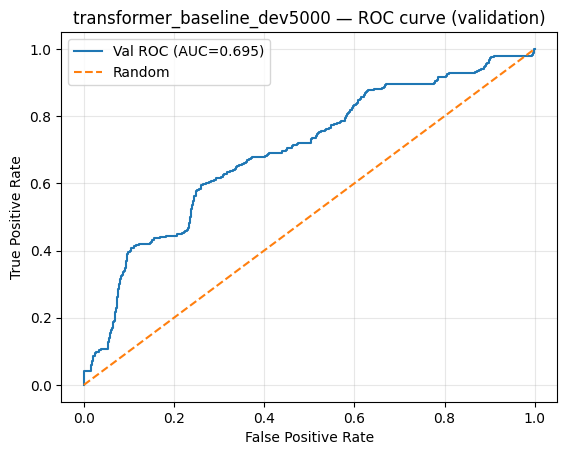

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_roc_val.png


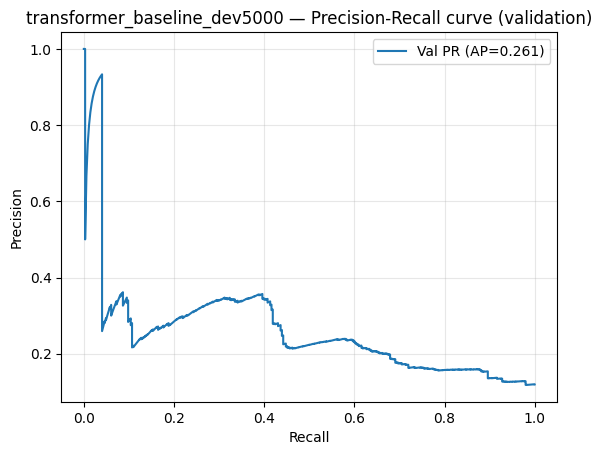

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_pr_val.png


In [20]:
## ROC + PR-kurvor (val) spara
# ROC (val)
fpr, tpr, _ = roc_curve(val_y, val_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"Val ROC (AUC={val_roc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{MODEL_TAG} — ROC curve (validation)")
plt.grid(True, alpha=0.3)
plt.legend()
out_roc_val = os.path.join(FIG_DIR, f"{MODEL_TAG}_roc_val.png")
plt.savefig(out_roc_val, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_roc_val)

# PR (val)
prec, rec, _ = precision_recall_curve(val_y, val_probs)
plt.figure()
plt.plot(rec, prec, label=f"Val PR (AP={val_pr:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{MODEL_TAG} — Precision-Recall curve (validation)")
plt.grid(True, alpha=0.3)
plt.legend()
out_pr_val = os.path.join(FIG_DIR, f"{MODEL_TAG}_pr_val.png")
plt.savefig(out_pr_val, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_pr_val)


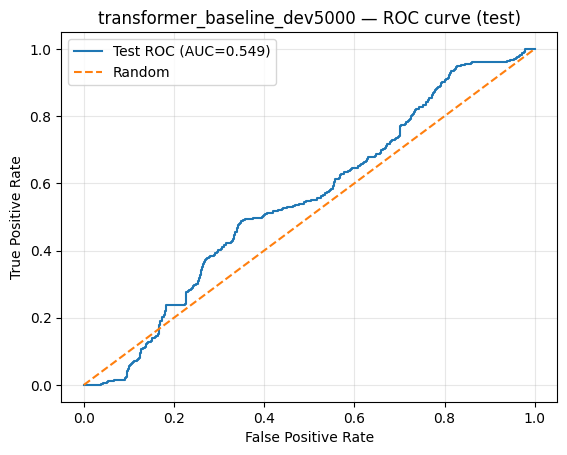

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_roc_test.png


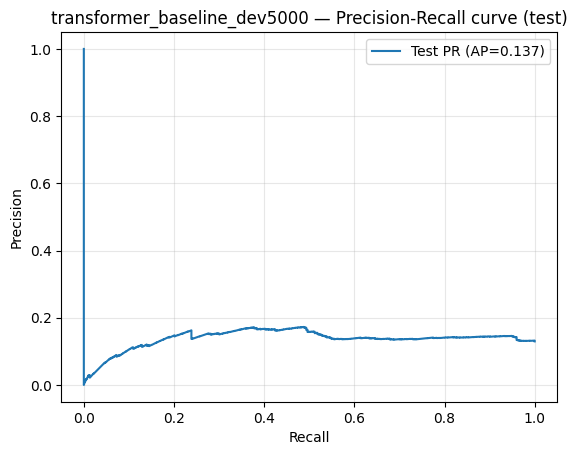

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_pr_test.png


In [21]:
## ROC + PR-kurvor (test) spara
# ROC (test)
fpr, tpr, _ = roc_curve(test_y, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"Test ROC (AUC={test_roc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{MODEL_TAG} — ROC curve (test)")
plt.grid(True, alpha=0.3)
plt.legend()
out_roc_test = os.path.join(FIG_DIR, f"{MODEL_TAG}_roc_test.png")
plt.savefig(out_roc_test, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_roc_test)

# PR (test)
prec, rec, _ = precision_recall_curve(test_y, test_probs)
plt.figure()
plt.plot(rec, prec, label=f"Test PR (AP={test_pr:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{MODEL_TAG} — Precision-Recall curve (test)")
plt.grid(True, alpha=0.3)
plt.legend()
out_pr_test = os.path.join(FIG_DIR, f"{MODEL_TAG}_pr_test.png")
plt.savefig(out_pr_test, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Sparad:", out_pr_test)


In [22]:
## Hitta bästa threshold på VAL (max F1), utvärdera på TEST
def best_threshold_by_f1(y_true, probs):
    thresholds = np.linspace(0.05, 0.95, 19)
    best_thr, best_f1 = 0.5, -1

    for thr in thresholds:
        y_pred = (probs >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        precision = tp / (tp + fp + 1e-12)
        recall    = tp / (tp + fn + 1e-12)
        f1        = 2 * precision * recall / (precision + recall + 1e-12)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr

    return float(best_thr), float(best_f1)

best_thr, best_f1 = best_threshold_by_f1(val_y, val_probs)
print(f"✅ Bästa threshold (VAL, max F1): {best_thr:.2f} | F1={best_f1:.3f}")


✅ Bästa threshold (VAL, max F1): 0.80 | F1=0.366


Confusion matrix (TEST):
[[1886  619]
 [ 262  111]]

Classification report (TEST):
              precision    recall  f1-score   support

           0      0.878     0.753     0.811      2505
           1      0.152     0.298     0.201       373

    accuracy                          0.694      2878
   macro avg      0.515     0.525     0.506      2878
weighted avg      0.784     0.694     0.732      2878



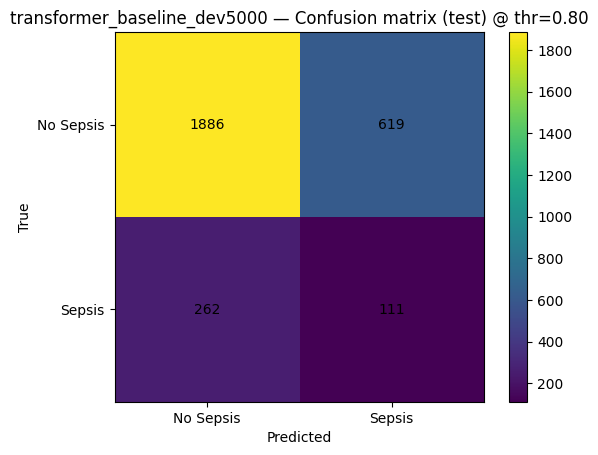

✅ Sparad: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/transformer_baseline_dev5000_confusion_test_thr0.80.png


In [23]:
# Confusion matrix + rapport (TEST) + spara figur
def plot_confusion(cm, title, out_path):
    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0, 1], ["No Sepsis", "Sepsis"])
    plt.yticks([0, 1], ["No Sepsis", "Sepsis"])
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # skriv siffror i rutor
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")

    plt.colorbar()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Sparad:", out_path)

test_pred = (test_probs >= best_thr).astype(int)
cm = confusion_matrix(test_y, test_pred)

print("Confusion matrix (TEST):")
print(cm)
print("\nClassification report (TEST):")
print(classification_report(test_y, test_pred, digits=3))

out_cm = os.path.join(FIG_DIR, f"{MODEL_TAG}_confusion_test_thr{best_thr:.2f}.png")
plot_confusion(cm, f"{MODEL_TAG} — Confusion matrix (test) @ thr={best_thr:.2f}", out_cm)


In [24]:
## Slutlig sammanfattning (för rapport/logg)
summary = {
    "model": MODEL_TAG,
    "processed_name": PROCESSED_NAME,
    "seq_len": int(SEQ_LEN),
    "num_features": int(NUM_FEATURES),
    "class_weight": class_weight,
    "val_roc_auc": float(val_roc),
    "val_pr_auc": float(val_pr),
    "test_roc_auc": float(test_roc),
    "test_pr_auc": float(test_pr),
    "best_threshold_val_f1": float(best_thr),
    "best_f1_val": float(best_f1),
    "checkpoint": ckpt_path,
    "figures": {
        "loss": os.path.basename(out_loss),
        "auc": os.path.basename(out_auc),
        "pr_auc": os.path.basename(out_pr),
        "roc_val": os.path.basename(out_roc_val),
        "pr_val": os.path.basename(out_pr_val),
        "roc_test": os.path.basename(out_roc_test),
        "pr_test": os.path.basename(out_pr_test),
        "cm_test": os.path.basename(out_cm),
    }
}

print("⭐ Transformer — sammanfattning:")
for k, v in summary.items():
    print("-", k, ":", v)


⭐ Transformer — sammanfattning:
- model : transformer_baseline_dev5000
- processed_name : dev5000
- seq_len : 48
- num_features : 80
- class_weight : {0: 0.5781714903976197, 1: 3.6980968858131487}
- val_roc_auc : 0.6948898284505629
- val_pr_auc : 0.26061028841125183
- test_roc_auc : 0.5493035376967246
- test_pr_auc : 0.13725421549437744
- best_threshold_val_f1 : 0.7999999999999999
- best_f1_val : 0.3657289002552602
- checkpoint : /content/drive/MyDrive/sepsis-timeline-project/outputs/checkpoints/best_transformer_baseline_dev5000.keras
- figures : {'loss': 'transformer_baseline_dev5000_learning_loss.png', 'auc': 'transformer_baseline_dev5000_learning_auc.png', 'pr_auc': 'transformer_baseline_dev5000_learning_pr_auc.png', 'roc_val': 'transformer_baseline_dev5000_roc_val.png', 'pr_val': 'transformer_baseline_dev5000_pr_val.png', 'roc_test': 'transformer_baseline_dev5000_roc_test.png', 'pr_test': 'transformer_baseline_dev5000_pr_test.png', 'cm_test': 'transformer_baseline_dev5000_confusion